In [1]:
import pandas as pd
drug = pd.read_csv("../data/eicu_demo/infusiondrug.csv")
bp = pd.read_csv("../data/eicu_demo/vitalPeriodic.csv")
diagnosis = pd.read_csv("../data/eicu_demo/diagnosis.csv")
patients_weight = pd.read_csv("../data/eicu_demo/patient.csv")[["patientunitstayid", "admissionweight"]]
drug = drug.merge(patients_weight, on="patientunitstayid")

In [2]:
# preproicess bp
bp = bp[~bp["systemicmean"].isna()]

In [3]:
#preprocess diagnosis
#diagnisis_filtered =

def contains_sepsis(value):
    for icd in sepsis_icd_codes:
        if value.lower().find(icd) != -1:
            return True
    return False

diagnosis[diagnosis["diagnosisstring"].str.lower().str.contains("sepsis")]
diagnosis = diagnosis[~diagnosis["icd9code"].isna()]
sepsis_icd_codes = ["r65.2", "r65.20", "r65.21", "995.92", "995.91", "a41.9"]
diagnosis_filtered = diagnosis[diagnosis.apply(lambda row: contains_sepsis(row["icd9code"]), axis=1)]

<ipython-input-4-9416b7d12209>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_mcg_kg_min["drugrate"] = drug_mcg_kg_min["drugrate"].astype("float")


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

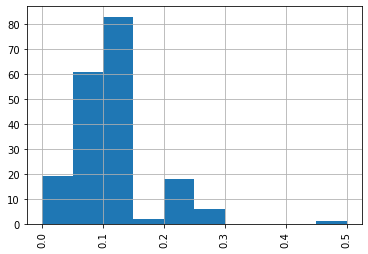

In [4]:
drug_mcg_kg_min = drug[(drug["drugname"] == "Norepinephrine (mcg/kg/min)")]
drug_mcg_kg_min["drugrate"] = drug_mcg_kg_min["drugrate"].astype("float")
drug_mcg_kg_min["drugrate"].hist()
import matplotlib.pyplot as plt
plt.xticks(rotation=90)

<ipython-input-5-e3f364a569bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"].astype(float)
<ipython-input-5-e3f364a569bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"] / drug_mcg_min["admissionweight"]


<AxesSubplot:>

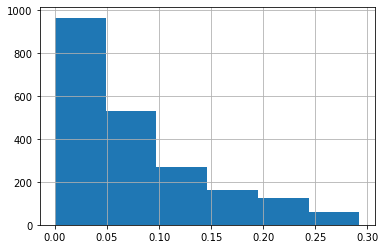

In [5]:
# I didnt solve hoe to do conversion

drug_mcg_min = drug[drug["drugname"] == "Norepinephrine (mcg/min)"]
drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"].astype(float)
drug_mcg_min["drugrate"] = drug_mcg_min["drugrate"] / drug_mcg_min["admissionweight"]
# print(drug_mcg_min["drugrate"].value_counts())
drug_mcg_min[drug_mcg_min["drugrate"] < 0.3]["drugrate"].hist(bins=6)
# plt.xticks(rotation=90)


In [6]:
# # we want mcg/kg/min, here it is probably ml/mg/hr

# drug_ml_hr = drug[drug["drugname"] == "Norepinephrine (ml/hr)"]
# drug_ml_hr["drugrate"] = (drug_ml_hr["drugrate"].astype(float) * 1000)/(60 * drug_ml_hr["admissionweight"])
# drug_ml_hr[drug_ml_hr["drugrate"] < 0.3]["drugrate"].hist()

In [7]:
# combine
drugs_converted = pd.concat([drug_mcg_min, drug_mcg_kg_min])
drugs_converted = drugs_converted[["patientunitstayid", "infusionoffset", "drugrate"]]
decisions_after_pipeline = drugs_converted.rename(columns={"patientunitstayid":"stay_id", "infusionoffset":"starttime", "drugrate":"originalrate"})
decisions_after_pipeline["endtime"] = decisions_after_pipeline["starttime"]

In [8]:
bp_filtered = bp[bp["patientunitstayid"].isin(diagnosis_filtered["patientunitstayid"].unique())]
bp_filtered = bp_filtered[bp_filtered["patientunitstayid"].isin(drugs_converted["patientunitstayid"].unique())]
stay_ids = bp_filtered.groupby(by="patientunitstayid").agg({"systemicmean":"count"})
stay_ids_with_enough_events = stay_ids[stay_ids["systemicmean"] > 10].index
bp_filtered = bp_filtered[bp_filtered["patientunitstayid"].isin(stay_ids_with_enough_events)]

In [9]:
bp_filtered = bp_filtered[["patientunitstayid", "observationoffset", "systemicmean"]]
bp_filtered = bp_filtered.rename(columns={"patientunitstayid":"stay_id", "observationoffset": "cur_bp_time", "systemicmean":"cur_bp"})
bp_filtered.loc[(bp_filtered["cur_bp"] >= 200), "cur_bp"] = 199
bp_filtered.loc[(bp_filtered["cur_bp"] <= 0), "cur_bp"] = 0

In [10]:
from tqdm import tqdm
import numpy as np
def doses_per_stay_id(stay_id, bps, doses):
    bps_stay_id_subset = bps[bps.stay_id == stay_id]
    doses_stay_id_subset = doses[doses.stay_id == stay_id]
    bps_stay_id_subset = bps_stay_id_subset.sort_values(by="cur_bp_time")
    bps_stay_id_subset["cur_avg_bp"] = bps_stay_id_subset["cur_bp"].rolling(3).mean()
    bps_stay_id_subset["next_bp"] = bps_stay_id_subset["cur_bp"].shift(-1)
    bps_stay_id_subset["next_bp_time"] = bps_stay_id_subset["cur_bp_time"].shift(-1)
    bps_stay_id_subset["next_avg_bp"] = bps_stay_id_subset["next_bp"].rolling(3).mean().shift(-2)
    if bps_stay_id_subset.shape[0] > 3:
        bps_stay_id_subset["cur_avg_bp"].iloc[0] = bps_stay_id_subset["cur_bp"].iloc[0]
        bps_stay_id_subset["cur_avg_bp"].iloc[1] =( bps_stay_id_subset["cur_bp"].iloc[0] + bps_stay_id_subset["cur_bp"].iloc[1])/2

        bps_stay_id_subset["next_avg_bp"].iloc[-2] = bps_stay_id_subset["next_bp"].iloc[-2]
        bps_stay_id_subset["next_avg_bp"].iloc[-3] = (bps_stay_id_subset["next_bp"].iloc[-3] + bps_stay_id_subset["next_bp"].iloc[-2])/2
    
    
        bps_stay_id_subset["dose"] = np.nan
        bps_stay_id_subset["dose"] = bps_stay_id_subset.apply(lambda row: match_dose(row, doses_stay_id_subset), axis=1)
    return bps_stay_id_subset

def match_dose(bp_row, doses):
        relevant_doses = doses[(bp_row["cur_bp_time"] <= doses["starttime"]) & 
                                    (bp_row["next_bp_time"] > doses["starttime"])]
        dose = relevant_doses.head(1)[["originalrate", "starttime", "endtime"]]
        if dose.size == 3:
            return dose.values[0][0]
        else:
            return None
        
def add_first_and_last_indicators(df):
    # add first and last indicators
    # sort by stay_id and cur_bp_time
    df = df.sort_values(["stay_id", "cur_bp_time"], ascending=False)
    df["last"] = df.groupby("stay_id").cumcount() == 0
    df = df.sort_values(["stay_id", "cur_bp_time"], ascending=True)
    df["first"] = df.groupby("stay_id").cumcount() == 0
    return df

def add_bp_catgeories(df):
    # get bins for dose and bp
    category_series= pd.cut(df.cur_bp, bins=BINS).astype(str)
    # set name to category
    category_series.name = "bp_category"
    # add the category column to the df
    df = df.join(category_series)
    next_category_series= pd.cut(df.next_bp, bins=BINS).astype(str)
    # set name to category
    next_category_series.name = "next_bp_category"
    df = df.join(next_category_series)
    return df

In [11]:
stay_ids = decisions_after_pipeline.stay_id.unique() 
bps_and_dose = None
for stay_id in tqdm(stay_ids):
    bps_and_dose_per_stay = doses_per_stay_id(stay_id, bp_filtered , decisions_after_pipeline)
    if bps_and_dose is not None:
        bps_and_dose = pd.concat([bps_and_dose, bps_and_dose_per_stay],axis=0)
    else:
        bps_and_dose = bps_and_dose_per_stay

  0%|                                                                                           | 0/90 [00:00<?, ?it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 24%|████████████████████                                                              | 22/90 [00:00<00:01, 53.54it/s]C:\Users\Yuval-PC\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
 28%|██████████████████████▊                                

In [12]:
bps_and_dose = bps_and_dose[~bps_and_dose["cur_bp"].isna()]

In [13]:
BINS = pd.IntervalIndex.from_tuples([(0,50),(50,60),(60,65),(65,70),(70,75),(75,80),(80,90),(90,200)], closed="left")
BINS

IntervalIndex([[0, 50), [50, 60), [60, 65), [65, 70), [70, 75), [75, 80), [80, 90), [90, 200)],
              closed='left',
              dtype='interval[int64]')

In [14]:


bps_and_dose["dose"] = bps_and_dose["dose"].fillna(0)
bps_and_dose = add_first_and_last_indicators(bps_and_dose)


In [15]:
bps_and_dose = bps_and_dose.fillna(0)

In [16]:
bps_and_dose["cur_avg_bp"] = bps_and_dose["cur_avg_bp"].astype(int)
bps_and_dose["next_avg_bp"] = bps_and_dose["next_avg_bp"].astype(int)
bps_and_dose["cur_bp"] = bps_and_dose["cur_bp"].astype(int)
bps_and_dose["next_bp"] = bps_and_dose["next_bp"].astype(int)
bps_and_dose = bps_and_dose.drop(columns=["cur_avg_bp", "next_avg_bp"])
#bps_and_dose = bps_and_dose.rename(columns={"cur_avg_bp":"cur_bp", "next_avg_bp":"next_bp"})
bps_and_dose = add_bp_catgeories(bps_and_dose)

In [17]:


bps_and_dose

,stay_id,cur_bp_time,cur_bp,next_bp,next_bp_time,dose,last,first,bp_category,next_bp_category
79582,249328,15,69,71,20.0,0.0,False,True,"[65, 70)","[70, 75)"
79744,249328,20,71,87,25.0,0.0,False,False,"[70, 75)","[80, 90)"
79174,249328,25,87,98,30.0,0.0,False,False,"[80, 90)","[90, 200)"
79816,249328,30,98,95,35.0,0.0,False,False,"[90, 200)","[90, 200)"
79906,249328,35,95,93,40.0,0.0,False,False,"[90, 200)","[90, 200)"
...,...,...,...,...,...,...,...,...,...,...
1608140,3239262,13642,162,156,13647.0,0.0,False,False,"[90, 200)","[90, 200)"
1608492,3239262,13647,156,136,13652.0,0.0,False,False,"[90, 200)","[90, 200)"
1606548,3239262,13652,136,199,13657.0,0.0,False,False,"[90, 200)","[90, 200)"
1606440,3239262,13657,199,199,13662.0,0.0,False,False,"[90, 200)","[90, 200)"


In [18]:
bps_and_dose.to_csv("eICU_bps_with_doses_no_average.csv")

# MIMIC 8 bins


In [33]:
mimic = pd.read_csv("../rnl/RNLData/MIMIC_bps_with_doses.csv")

In [35]:
mimic["cur_bp"] = mimic["cur_bp"].astype(int)
mimic["next_bp"] = mimic["next_bp"].fillna(0).astype(int)

In [36]:
mimic = mimic.drop(columns=["bp_category", "next_bp_category", "Unnamed: 0"])

In [37]:
mimic_8_bins = add_bp_catgeories(mimic)

In [38]:
mimic_8_bins.to_csv("../rnl/RNLData/MIMIC_bps_with_doses_8_bins.csv")